In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# Encoding char
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

# Decoding to char
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# Creating the dataset
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        
        # Use a rolling window to update context
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [20]:
# Putting it into a function

block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev     = build_dataset(words[n1:n2])
Xtest, Ytest   = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [40]:
# Roughly Sketching out the Architecture

In [21]:
# Creating Embedding Table (Embedding Dimension is set to 2)

C = torch.randn((27,2))

In [22]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [28]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [29]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [30]:
h

tensor([[ 1.0000, -0.9937,  1.0000,  ...,  0.9998,  0.9999, -0.8253],
        [ 1.0000, -0.9998,  1.0000,  ...,  1.0000,  0.9998, -0.9744],
        [ 0.9956, -0.4456,  0.9998,  ...,  0.9895, -0.2403,  0.3361],
        ...,
        [ 0.9684, -0.9837,  0.9952,  ...,  0.9704, -0.9795, -0.0392],
        [ 0.9932, -0.9707,  1.0000,  ...,  0.9987,  0.9764, -0.5808],
        [ 0.9992, -0.9939,  1.0000,  ...,  1.0000,  0.2938, -0.8991]])

In [31]:
h.shape

torch.Size([228146, 100])

In [32]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [33]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [34]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)
probs.shape

torch.Size([228146, 27])

In [39]:
loss = -probs[torch.arange(32), Y[:32]].log().mean()
loss

tensor(20.5245)

In [91]:
# Summarized

In [92]:
# Dataset

Xtrain.shape, Ytrain.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [93]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
paramters = [C, W1, b1, W2, b2]

In [94]:
# Total number of parameters

sum(p.nelement() for p in paramters)

11897

In [95]:
for p in paramters:
    p.requires_grad = True

In [96]:
# Learning rate exponents

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [97]:
lri   = []
lossi = []
stepi = []

In [98]:
# Creating a Training Loop

for i in range(600000):
    
    # Mini-batches of size 32     
    ix = torch.randint(0, Xtrain.shape[0], (32, ))
    
    # Forward pass
    emb    = C[Xtrain[ix]] # (32, 3, 10)
    h      = torch.tanh(emb.view(-1, 30) @ W1 + b1 ) # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss   = F.cross_entropy(logits, Ytrain[ix])
    
    # Backward pass
    for p in paramters:
        p.grad = None
        
    loss.backward()
    
    # Optimizer step
    lr = 0.1 if i < 300000 else 0.1
    for p in paramters:
        p.data += -lr * p.grad
        
    # Collecting metrics
    lossi.append(loss.log10().item())
    stepi.append(i)

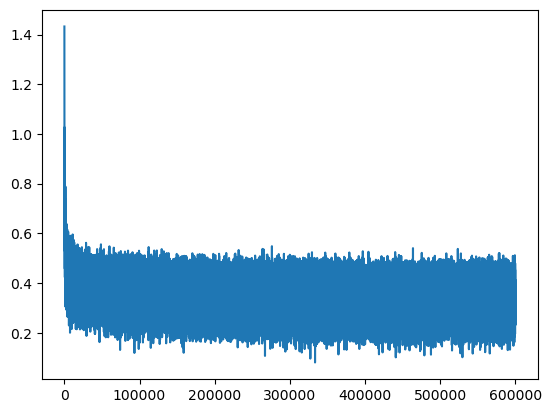

In [99]:
plt.plot(stepi, lossi)

In [100]:
# Calculating loss on entire training set
emb    = C[Xtrain] 
h      = torch.tanh(emb.view(-1, 30) @ W1 + b1 ) 
logits = h @ W2 + b2  
loss   = F.cross_entropy(logits, Ytrain)
loss.item()

2.159823179244995

In [101]:
# Calculating loss on entire dev set
emb    = C[Xdev] 
h      = torch.tanh(emb.view(-1, 30) @ W1 + b1 ) 
logits = h @ W2 + b2  
loss   = F.cross_entropy(logits, Ydev)
loss.item()

2.24430775642395

In [102]:
# Visualizing the first two dimensions of the character embeddings

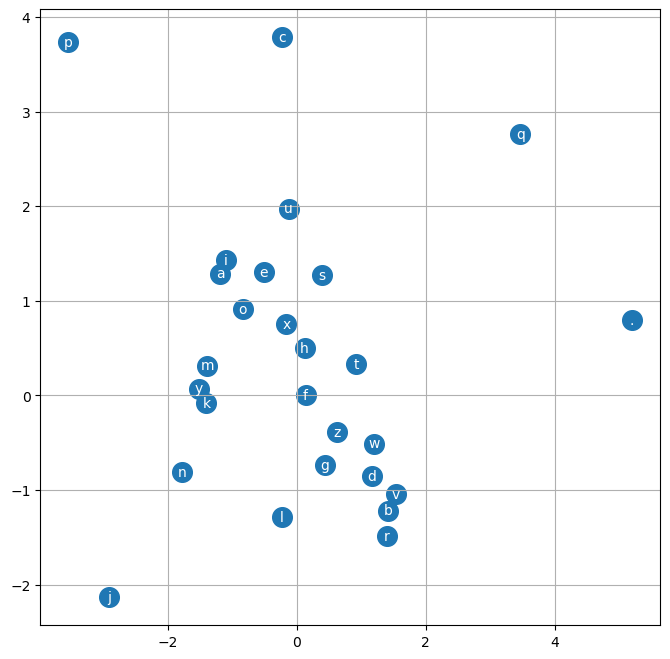

In [103]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')

In [104]:
# Using the model as a generator

In [105]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
        logits = h @ W2 + b2 
        probs  = F.softmax(logits, dim=1)
        idx_next = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [idx_next]
        out.append(idx_next)
        
        if idx_next == 0:
            break
            
    print("".join(itos[i] for i in out))

carmah.
aal.
harlin.
mil.
rey.
cassand.
kenzzon.
nadelynn.
jaheli.
ner.
kiah.
maiah.
kaleigh.
ham.
joss.
quint.
shon.
walianni.
walelo.
dearyn.
